DATA CLEANING

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('tweet_emotions.csv')

# Display the first few rows of the dataframe
print(df.head())

# Basic information about dataset
print(df.info())


     tweet_id   sentiment                                            content  \
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...   
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2  1956967696     sadness                Funeral ceremony...gloomy friday...   
3  1956967789  enthusiasm               wants to hang out with friends SOON!   
4  1956968416     neutral  @dannycastillo We want to trade with someone w...   

                                     cleaned_content  \
0  tiffanylue i know  i was listenin to bad habit...   
1  layin n bed with a headache  ughhhhwaitin on y...   
2                      funeral ceremonygloomy friday   
3                wants to hang out with friends soon   
4  dannycastillo we want to trade with someone wh...   

                                   encrypted_content  randomized_length  
0  ynkkfs~qzj%n%pst|%%n%|fx%qnxyjsns%yt%gfi%mfgny...                 88  
1  qf~ns%s%gji%|nym%f%mjfifhmj%%zl

In [2]:
import re

def clean_text(text):
    """ Clean text by removing special characters and numbers."""
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

df.to_csv('tweet_emotions.csv', index=False)

# Show cleaned text
print(df[['content', 'cleaned_content']].head())


                                             content  \
0  @tiffanylue i know  i was listenin to bad habi...   
1  Layin n bed with a headache  ughhhh...waitin o...   
2                Funeral ceremony...gloomy friday...   
3               wants to hang out with friends SOON!   
4  @dannycastillo We want to trade with someone w...   

                                     cleaned_content  
0  tiffanylue i know  i was listenin to bad habit...  
1  layin n bed with a headache  ughhhhwaitin on y...  
2                      funeral ceremonygloomy friday  
3                wants to hang out with friends soon  
4  dannycastillo we want to trade with someone wh...  


EXPLORATORY DATA ANALYSIS

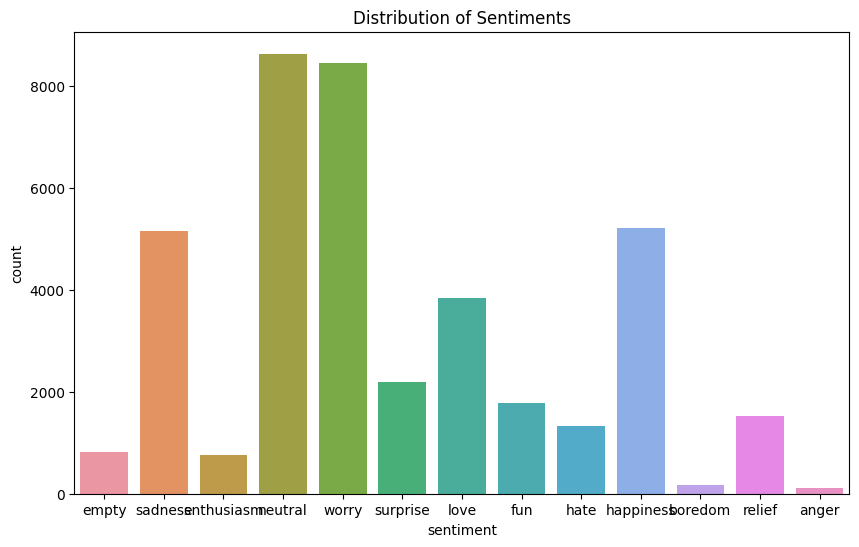

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.show()


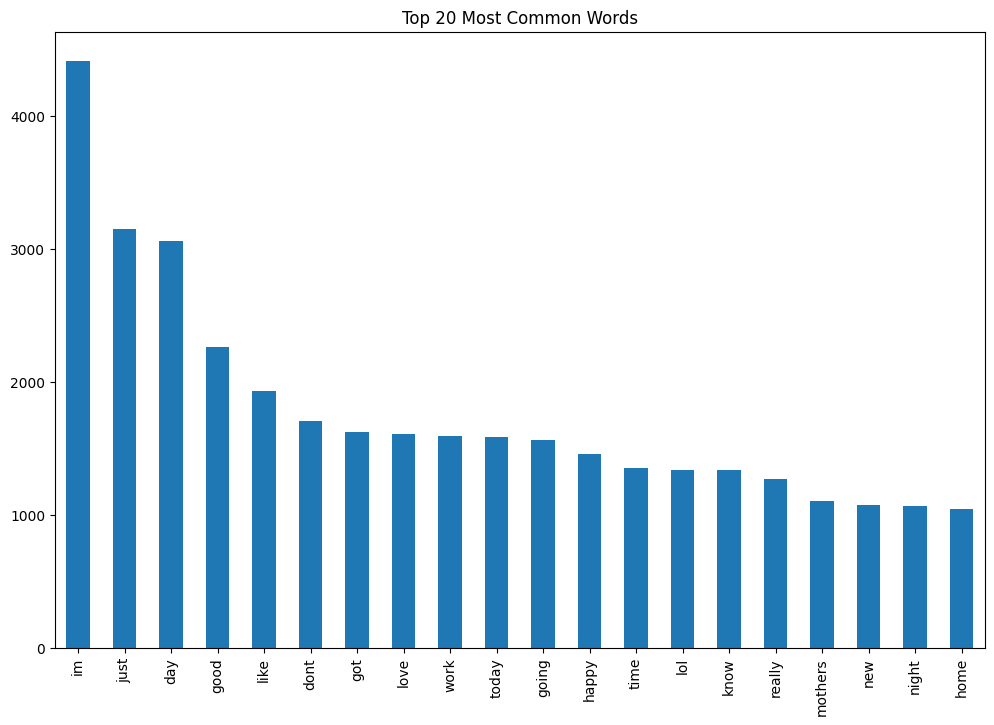

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Vectorize the cleaned text and calculate word frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_content'])

# Sum up the counts of each vocabulary word
# Use get_feature_names_out() instead of get_feature_names()
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_totals = word_counts.sum(axis=0).sort_values(ascending=False)

# Plot the most common words
plt.figure(figsize=(12, 8))
word_totals.head(20).plot(kind='bar')
plt.title('Top 20 Most Common Words')
plt.show()


In [5]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


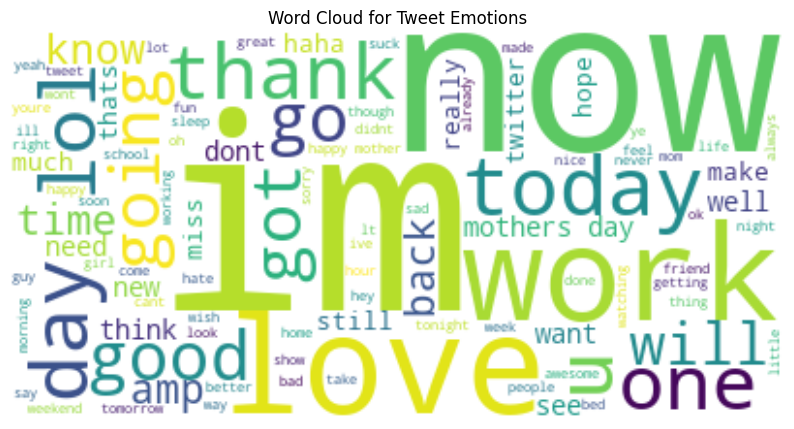

In [42]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=100).generate(' '.join(df['cleaned_content']))

# Display the generated image:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Tweet Emotions')
plt.show()


Converting text data into numerics

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using TF-IDF to transform text into a meaningful representation of numbers
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
features = tfidf.fit_transform(df['cleaned_content'])
print(features.shape)


(40000, 1000)


ENCRYPTION , AGGREGATION AND RANDOMIZATION

In [44]:
def simple_encrypt(text, shift=5):
    encrypted_text = ''.join(chr((ord(char) + shift) % 256) for char in text)
    return encrypted_text

df['encrypted_content'] = df['cleaned_content'].apply(simple_encrypt)
df.to_csv('tweet_emotions.csv', index=False)
print(df[['cleaned_content', 'encrypted_content']].head())


                                     cleaned_content  \
0  tiffanylue i know  i was listenin to bad habit...   
1  layin n bed with a headache  ughhhhwaitin on y...   
2                      funeral ceremonygloomy friday   
3                wants to hang out with friends soon   
4  dannycastillo we want to trade with someone wh...   

                                   encrypted_content  
0  ynkkfs~qzj%n%pst|%%n%|fx%qnxyjsns%yt%gfi%mfgny...  
1  qf~ns%s%gji%|nym%f%mjfifhmj%%zlmmmm|fnyns%ts%~...  
2                      kzsjwfq%hjwjrts~lqttr~%kwnif~  
3                |fsyx%yt%mfsl%tzy%|nym%kwnjsix%xtts  
4  ifss~hfxynqqt%|j%|fsy%yt%ywfij%|nym%xtrjtsj%|m...  


USING MPC ENCRYPTION

In [71]:
pip install mpyc

   ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
   ---------- ----------------------------- 30.7/112.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 112.2/112.2 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [72]:
from mpyc.runtime import mpc
import pandas as pd

async def encrypt_and_store_data():
    await mpc.start()  # Start the MPyC runtime

    # Load the dataset
    df = pd.read_csv('tweet_emotions.csv')

    
    contents = df['content'].tolist()  

    
    secint = mpc.SecInt()  # You might specify the bit length like mpc.SecInt(32) if needed

    # Secret sharing each content length
    encrypted_contents = [mpc.input(secint(len(content)), senders=0) for content in contents]

    # Simulate retrieval of "encrypted" data to show
    encrypted_samples = await mpc.gather(encrypted_contents)  # Gather all encrypted data

    # Shutdown the MPyC runtime
    await mpc.shutdown()

    # Add encrypted data as a new column to the dataframe
    df['encrypted_length'] = encrypted_samples
    return df

if __name__ == "__main__":
    encrypted_df = mpc.run(encrypt_and_store_data())
    print("Dataframe with encrypted lengths:", encrypted_df.head())


2024-05-02 21:13:58,816 Install package gmpy2 for better performance.


2024-05-02 21:13:58,911 Start MPyC runtime v0.10
2024-05-02 21:14:00,613 Stop MPyC -- elapsed time: 0:00:01.702|bytes sent: 0
Dataframe with encrypted lengths:      tweet_id   sentiment                                            content  \
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...   
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2  1956967696     sadness                Funeral ceremony...gloomy friday...   
3  1956967789  enthusiasm               wants to hang out with friends SOON!   
4  1956968416     neutral  @dannycastillo We want to trade with someone w...   

                                     cleaned_content  \
0  tiffanylue i know  i was listenin to bad habit...   
1  layin n bed with a headache  ughhhhwaitin on y...   
2                      funeral ceremonygloomy friday   
3                wants to hang out with friends soon   
4  dannycastillo we want to trade with someone wh...   

                      

In [45]:
import numpy as np

def randomize_length(text):
    original_length = len(text)
    noise = np.random.normal(loc=0, scale=1)  # Adding Gaussian noise
    randomized_length = max(1, int(original_length + noise))
    return randomized_length

df['randomized_length'] = df['cleaned_content'].apply(randomize_length)
df.to_csv('tweet_emotions.csv', index=False)
print(df[['cleaned_content', 'randomized_length']].head())


                                     cleaned_content  randomized_length
0  tiffanylue i know  i was listenin to bad habit...                 88
1  layin n bed with a headache  ughhhhwaitin on y...                 53
2                      funeral ceremonygloomy friday                 29
3                wants to hang out with friends soon                 36
4  dannycastillo we want to trade with someone wh...                 82


In [46]:
df['encrypted_content']

0        ynkkfs~qzj%n%pst|%%n%|fx%qnxyjsns%yt%gfi%mfgny...
1        qf~ns%s%gji%|nym%f%mjfifhmj%%zlmmmm|fnyns%ts%~...
2                            kzsjwfq%hjwjrts~lqttr~%kwnif~
3                      |fsyx%yt%mfsl%tzy%|nym%kwnjsix%xtts
4        ifss~hfxynqqt%|j%|fsy%yt%ywfij%|nym%xtrjtsj%|m...
                               ...                        
39995                                      otmsqqt~iyf~qtw
39996                       mfuu~%rtymjwx%if~%%fqq%r~%qt{j
39997    mfuu~%rtymjwx%if~%yt%fqq%ymj%rtrrnjx%tzy%ymjwj...
39998    snfwnqj~%|fxxzu%gjfzynkzq%ktqqt|%rj%%ujju%tzy%...
39999    rtujiwtsns%gzqqjy%ywfns%kwtr%ytp~t%%%%ymj%lk%f...
Name: encrypted_content, Length: 40000, dtype: object

In [47]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib

# Load data
df = pd.read_csv('tweet_emotions.csv')
df['encrypted_content'].fillna('missing', inplace=True)  # Replace NaNs


C:\Users\uk029\AppData\Local\Temp\ipykernel_23516\2286830846.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['encrypted_content'].fillna('missing', inplace=True)  # Replace NaNs


SIMPLE TRANSFORMER

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd

# Load the dataset
df = pd.read_csv('tweet_emotions.csv')

# Handle missing values
df['encrypted_content'].fillna('missing', inplace=True)

# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('tfidf', CountVectorizer(), 'encrypted_content'),
        ('scaler', MinMaxScaler(), ['randomized_length'])
    ],
    remainder='drop'
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', MultinomialNB())
])

# Prepare features and labels
features = df[['encrypted_content', 'randomized_length']]
labels = df['sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'sentiment_analysis_model.pkl')


C:\Users\uk029\AppData\Local\Temp\ipykernel_23516\839636693.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['encrypted_content'].fillna('missing', inplace=True)


['sentiment_analysis_model.pkl']

In [77]:
def predict_sentiment(text, length):
    model = joblib.load('sentiment_analysis_model.pkl')
    input_df = pd.DataFrame({'encrypted_content': [text], 'randomized_length': [length]})
    sentiment = model.predict(input_df)[0]
    return sentiment

# Example usage
if __name__ == "__main__":
    test_text = "i should be sleep but im not thinking about an old friend who i want but hes married now damn amp he wants me scandalous"
    test_length = 100  # Example length
    predicted_sentiment = predict_sentiment(test_text, test_length)
    print(f"The predicted sentiment of the text is: {predicted_sentiment}")


The predicted sentiment of the text is: worry


Accuracy: 0.3035


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.34      0.26      0.29      1028
        hate       0.50      0.01      0.01       268
        love       0.51      0.26      0.35       762
     neutral       0.33      0.36      0.35      1740
      relief       0.00      0.00      0.00       352
     sadness       0.33      0.09      0.14      1046
    surprise       0.00      0.00      0.00       425
       worry       0.27      0.75      0.39      1666

    accuracy                           0.30      8000
   macro avg       0.18      0.13      0.12      8000
weighted avg       0.28      0.30      0.25      8000



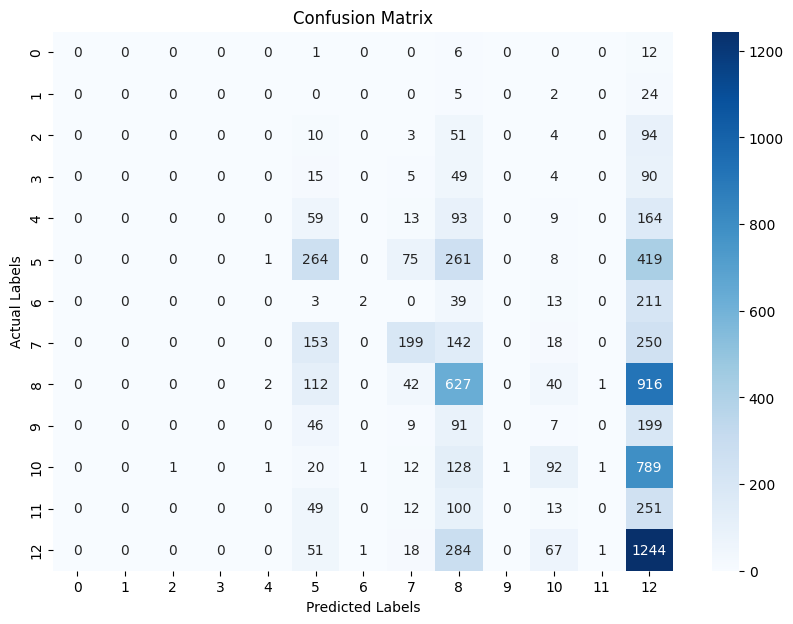

In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = joblib.load('sentiment_analysis_model.pkl')

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [79]:
from sklearn.model_selection import GridSearchCV

# Define a new pipeline with a placeholder for the classifier
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', MultinomialNB())
])

# Setup the grid search parameters
param_grid = {
    'classifier__alpha': [0.01, 0.1, 1.0, 10.0],
    'preprocessor__tfidf__max_features': [500, 1000, 1500],
    'preprocessor__tfidf__ngram_range': [(1, 1), (1, 2)]
}

# Setup the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Improved Accuracy: {best_accuracy}")


Best parameters: {'classifier__alpha': 10.0, 'preprocessor__tfidf__max_features': 1500, 'preprocessor__tfidf__ngram_range': (1, 2)}
Best cross-validation score: 0.33
Improved Accuracy: 0.3295


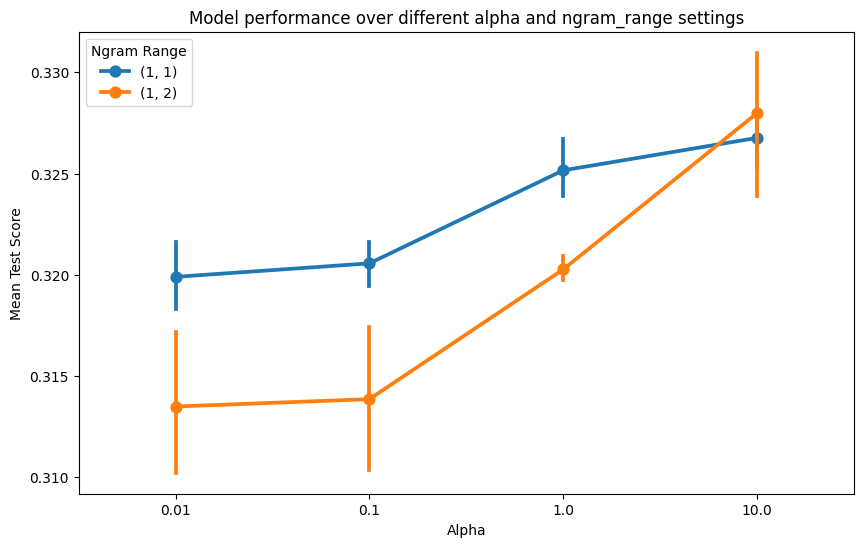

In [80]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.pointplot(data=results, x='param_classifier__alpha', y='mean_test_score', hue='param_preprocessor__tfidf__ngram_range')
plt.title('Model performance over different alpha and ngram_range settings')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.legend(title='Ngram Range')
plt.show()


NEURAL NETWORKS

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 13)                3341      
                                                                 
Total params: 647181 (2.47 MB)
Trainable params: 647181 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/10
450/450 [==============================] - 5s 9ms/step - loss: 2.0544 - accuracy: 0.2835 - val_loss: 1.9441 - val_accuracy: 0.3266
Epoch 2/10
450/450 [==============================] - 4s 9ms/step - loss: 1.8814 - accuracy: 0.3586 - val_loss: 1.9239 - val_accuracy: 0.3322
Epoch 3/10
450/450 [==============================] - 4s 9ms/step - loss: 1.7989 - accuracy: 0.3858 - val_loss: 1.9282 - val_accuracy: 0.3347
Epoch 4/10
450/450 [==============================] - 4s 10ms/step - loss: 1.7221 - accuracy: 0.4152 - val_loss: 1.9505 - val_accuracy: 0.3291
Epoch 5/10
450/450 [==============================] - 5s 11ms/step - loss: 1.6392 - accuracy: 0.4417 - val_loss: 1.9713 - val_accuracy: 0.3278
Epoch 6/10
450/450 [==============================] - 5s 11ms/step - loss: 1.5351 - accuracy: 0.4775 - val_loss: 2.0181 - val_accuracy: 0.3262
Epoch 7/10
450/450 [==============================] - 4s 9ms/step - loss: 1.4299 - accuracy: 0.5158 - val_loss: 2.0675 - val_accuracy: 0.3275
Epo

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy:.2f}")


250/250 - 1s - loss: 2.2725 - accuracy: 0.3149 - 903ms/epoch - 4ms/step
Test accuracy: 0.31


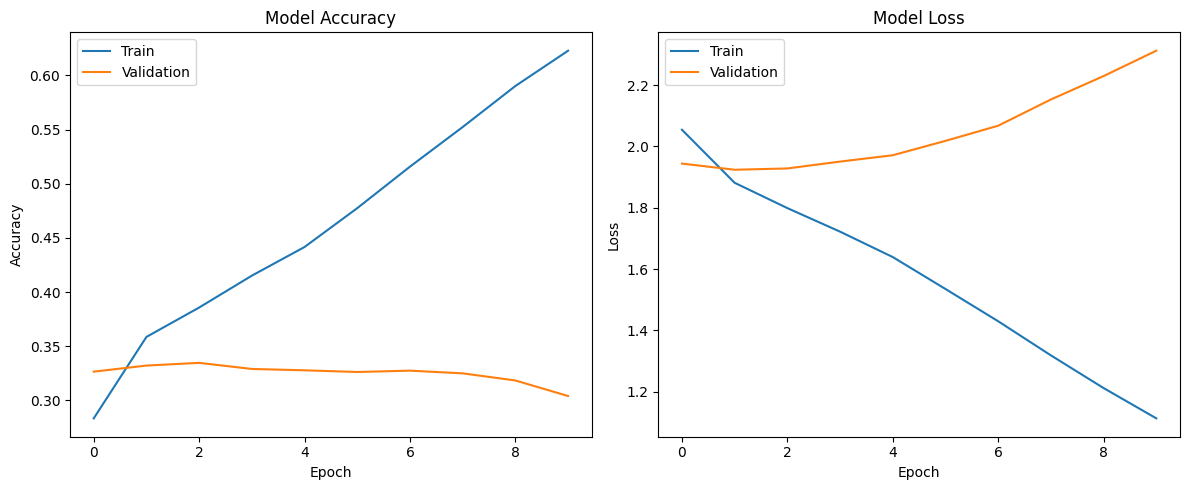

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


FINAL BEST MODEL

In [49]:
import os, sys, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

SEED = 42
keras.utils.set_random_seed(SEED)

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
df = pd.read_csv(
    'tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df.rename(columns={'content': 'sentence', 'sentiment': 'label'}, inplace=True)

df = df[ (df.label == 'happiness') | (df.label == 'sadness') ]
df.label = df.label.cat.remove_unused_categories()

label_names = df.label.cat.categories.tolist()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

print(f'{len(train_df)=}, {len(test_df)=}')
print(label_names)

len(train_df)=8299, len(test_df)=2075
['happiness', 'sadness']


,label,sentence
23531,sadness,&quot;My problem isn't that I miss you... 'cau...
8051,sadness,That's it? It's done already? This is one proo...
11499,sadness,I am so hungry! And there is no food for me to...
31288,happiness,Feet hurt...finally in bed...will not forget t...
18561,sadness,really ill atm


,label,sentence
11535,sadness,looks like we're rained out for weekend climbing
32287,sadness,Hi Everyone miss me much? muahhhhhhhhhhhhhhhh...
17534,sadness,"rode the moped to the mall. fun stuff, its fli..."
4696,sadness,gutted!!! vodafone wont repair my faulty Samsu...
23706,happiness,"@shadowowns aww, &lt;3 why thank youu."


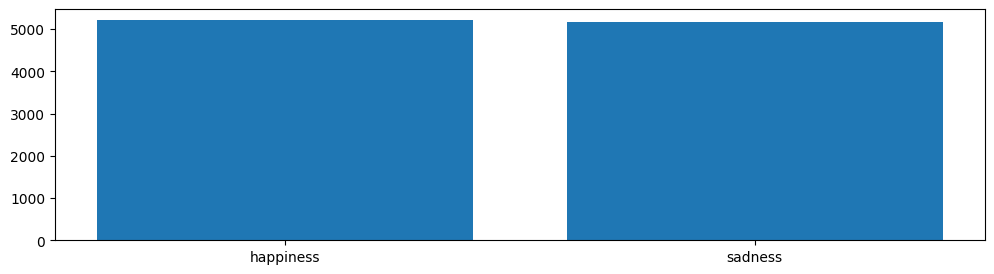

In [51]:
display(train_df.head())
display(test_df.head())

plt.figure(figsize=(12,3))
plt.bar(x=label_names, height=np.bincount(df['label'].cat.codes))

class_weights = dict(enumerate(
    compute_class_weight(
        class_weight="balanced", 
        classes=pd.unique(df['label']), 
        y=df['label']
    )
))

In [52]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUMBERS = re.compile('\d+')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
    
def clean_text(text):   
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'http\S+', '') 
    text = tf.strings.regex_replace(text, '([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ')
    text = tf.strings.regex_replace(text, '[/(){}\[\]\|@,;]', ' ')
    text = tf.strings.regex_replace(text, '[^0-9a-z #+_]', '')
    text = tf.strings.regex_replace(text, '[\d+]', '')
    return text
    
def lemmatize_tokenize(text):
    # TODO: rework to use tf.strings
    # remove stopwords and lemmatize
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [53]:
N_CLASSES = len(label_names)
MAX_FEATURES = 5_000
MAX_SEQ_LEN = 256
EMBEDDING_DIM = 128

vectorizer_layer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=clean_text,
#     split=lemmatize_tokenize,
    output_sequence_length=MAX_SEQ_LEN,
    output_mode='int'
)
vectorizer_layer.adapt(train_df.sentence)

In [54]:
model = models.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorizer_layer,
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
    
    layers.SpatialDropout1D(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='gelu'),
    layers.Dropout(0.4),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [55]:
X_train, y_train = train_df.sentence, train_df.label.cat.codes
X_test,  y_test  =  test_df.sentence,  test_df.label.cat.codes

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=300,
    verbose=1,
    class_weight=class_weights,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/300
33/33 [==============================] - 3s 67ms/step - loss: 0.6891 - accuracy: 0.5473 - val_loss: 0.6776 - val_accuracy: 0.6766
Epoch 2/300
33/33 [==============================] - 2s 57ms/step - loss: 0.6447 - accuracy: 0.6823 - val_loss: 0.5812 - val_accuracy: 0.7504
Epoch 3/300
33/33 [==============================] - 2s 59ms/step - loss: 0.4955 - accuracy: 0.7841 - val_loss: 0.4512 - val_accuracy: 0.7913
Epoch 4/300
33/33 [==============================] - 2s 55ms/step - loss: 0.3982 - accuracy: 0.8220 - val_loss: 0.4295 - val_accuracy: 0.8106
Epoch 5/300
33/33 [==============================] - 2s 56ms/step - loss: 0.3452 - accuracy: 0.8556 - val_loss: 0.4194 - val_accuracy: 0.8106
Epoch 6/300
33/33 [==============================] - 2s 61ms/step - loss: 0.3048 - accuracy: 0.8750 - val_loss: 0.4184 - val_accuracy: 0.8092
Epoch 7/300
33/33 [==============================] - 2s 71ms/step - loss: 0.2675 - accuracy: 0.8936 - val_loss: 0.4217 - val_accuracy: 0.8092
Epoch 

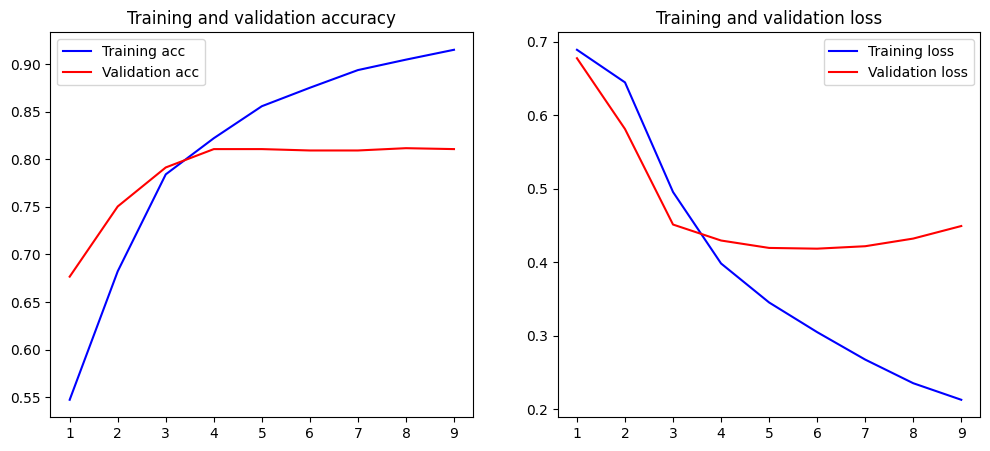

In [56]:
def plot_history(history):
    acc,  val_acc  = history['accuracy'],  history['val_accuracy']
    loss, val_loss = history['loss'], history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)
    
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy'); plt.legend(); plt.subplot(1, 2, 2)
    
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss'); plt.legend(); plt.show()
    
plot_history(history.history)

65/65 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

   happiness       0.80      0.83      0.81      1015
     sadness       0.83      0.80      0.81      1060

    accuracy                           0.81      2075
   macro avg       0.81      0.81      0.81      2075
weighted avg       0.81      0.81      0.81      2075



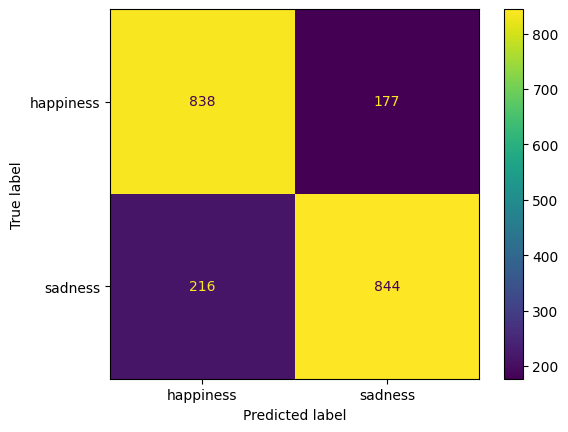

In [57]:
y_pred = model.predict(X_test).argmax(1)

print(classification_report(
    y_test, y_pred, target_names=label_names
))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_names
)

In [60]:
model.save('sentiment-for-nova.keras')

TRANSFORMER MODEL 3 

In [61]:
import pandas as pd
import seaborn as sns

In [62]:
df = pd.read_csv(
    'tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df = df.rename(columns={'content': 'tweet', 'sentiment': 'label'})
#labels = ['sadness', 'neutral', 'happiness', 'worry', 'love']
labels = ['neutral', 'sadness', 'happiness']
df = df.query('label in @labels')
df.label = df.label.cat.remove_unused_categories()
# Rename labels
df['label'] = df['label'].replace('sadness', 'negative')
#df['label'] = df['label'].replace('worry', 'negative')
df['label'] = df['label'].replace('happiness', 'positive')
#df['label'] = df['label'].replace('love', 'positive')
data = df.dropna().reset_index(drop=True)

C:\Users\uk029\AppData\Local\Temp\ipykernel_23516\1167753882.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['label'] = df['label'].replace('sadness', 'negative')
C:\Users\uk029\AppData\Local\Temp\ipykernel_23516\1167753882.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['label'] = df['label'].replace('happiness', 'positive')


In [63]:
data_pos = data.query('label == "positive"')[:300]
data_neu = data.query('label == "neutral"')[:300]
data_neg = data.query('label == "negative"')[:300]

data_final = pd.concat([data_pos, data_neu, data_neg])

c:\Users\uk029\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

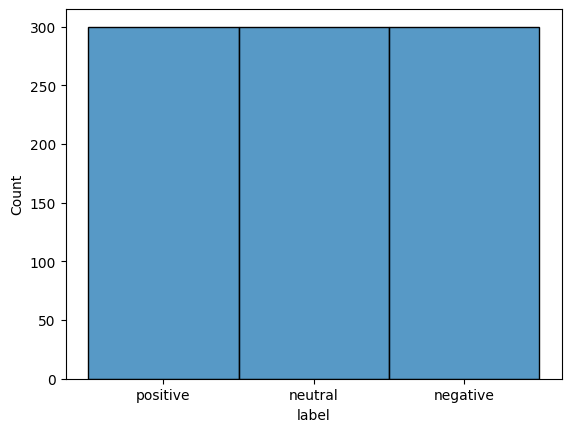

In [64]:
sns.histplot(data_final, x='label')

In [65]:
import keras
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
)

c:\Users\uk029\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\uk029\.cache\huggingface\hub\models--lxyuan--distilbert-base-multilingual-cased-sentiments-student. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [66]:
distilled_student_sentiment_classifier("I love this movie and i would watch it again and again!")

[{'label': 'positive', 'score': 0.9731044769287109}]

In [67]:
cardiffnlp_sentiment_classifier = pipeline(
    model='cardiffnlp/twitter-roberta-base-sentiment-latest',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest'
)

c:\Users\uk029\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\uk029\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at cardiffnlp/twitter-ro

In [68]:
finiteautomata_sentiment_classifier = pipeline(
    model='finiteautomata/bertweet-base-sentiment-analysis',
    tokenizer='finiteautomata/bertweet-base-sentiment-analysis'
)

c:\Users\uk029\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\uk029\.cache\huggingface\hub\models--finiteautomata--bertweet-base-sentiment-analysis. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
emoji is not installed, thus not converting emoticons or emoji

In [69]:
finiteautomata_sentiment_classifier("I love this movie and i would watch it again and again!")

[{'label': 'POS', 'score': 0.9923557043075562}]